# Task5

## Import data

In [2]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.utils import pad_sequences 

max_features = 10000 # vocabulary size
max_len = 250 # words per sample 

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features) 

# pad all samples to same length 
x_train = pad_sequences(x_train, maxlen=max_len, padding='post') 
x_test = pad_sequences(x_test, maxlen=max_len, padding='post')

## Positional embedding

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, seq_len, vocab_size, emb_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=emb_dim)
        self.pos_emb = layers.Embedding(input_dim=seq_len, output_dim=emb_dim)

    def call(self, x_input):
        seq_len = tf.shape(x_input)[-1]
        positions = tf.range(start=0, limit=seq_len, delta=1)
        positions = self.pos_emb(positions)
        x_input = self.token_emb(x_input)
        return x_input + positions
    


## Modeling

In [ ]:
from tensorflow.keras.layers import MultiHeadAttention, Dense, GlobalAveragePooling1D, Dropout, Input
from tensorflow.keras import Model

num_heads = 2 # number of attention heads 
embed_dim = 32
dense_dim = 64
key_dim = embed_dim // num_heads # query/key dimension for one head

inputs = Input(shape=(max_len,)) 
x = TokenAndPositionEmbedding(max_len, max_features, embed_dim)(inputs) 

# TransformerEncoder
attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x) 
proj_input = layers.LayerNormalization()(attention_output + x) # With residual
proj_output = Dense(dense_dim, activation='relu')(proj_input)
proj_output = Dense(embed_dim)(proj_output)
x = layers.LayerNormalization()(proj_input + proj_output)

x = GlobalAveragePooling1D()(x) # With residual
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x) 
att_model = Model(inputs=inputs, outputs=outputs) 

att_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 

att_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 250)]        0           []                               
                                                                                                  
 token_and_position_embedding_1  (None, 250, 32)     328000      ['input_13[0][0]']               
 2 (TokenAndPositionEmbedding)                                                                    
                                                                                                  
 multi_head_attention_12 (Multi  (None, 250, 32)     4224        ['token_and_position_embedding_12
 HeadAttention)                                                  [0][0]',                         
                                                                  'token_and_position_embedd

## Fit model

In [24]:
att_model.fit(x_train, y_train, epochs=5, batch_size=32)

Epoch 1/5
782/782 [==============================] - 9s 10ms/step - loss: 0.3952 - accuracy: 0.8147
Epoch 2/5
782/782 [==============================] - 8s 10ms/step - loss: 0.2311 - accuracy: 0.9070
Epoch 3/5
782/782 [==============================] - 8s 10ms/step - loss: 0.1803 - accuracy: 0.9344
Epoch 4/5
782/782 [==============================] - 8s 10ms/step - loss: 0.1477 - accuracy: 0.9452
Epoch 5/5
782/782 [==============================] - 8s 10ms/step - loss: 0.1210 - accuracy: 0.9589


## Evaluate model performance

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

loss, accuracy = att_model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

782/782 [==============================] - 4s 5ms/step - loss: 0.4586 - accuracy: 0.8437
Test Loss: 0.458557665348053
Test Accuracy: 0.8436800241470337


## Attnetion scores

In [26]:
# Create a model for outputting attention scores

inps = att_model.input
embedding_output = att_model.layers[1](inps)
att_output, att_scores = att_model.layers[2](embedding_output, embedding_output, return_attention_scores=True)
score_model = Model(inputs=inps, outputs=[att_output, att_scores])

sample_input = x_train[:1]  # a single training example
_, attention_scores_all = score_model.predict(sample_input)

# scores for a single attention head
head_index = 1
attention_scores = attention_scores_all[0][head_index] 

# Verify the shape of attention scores
print(f"Attention scores, full shape: {attention_scores_all.shape}")
print(f"Attention scores, one head: {attention_scores.shape}")

1/1 [==============================] - 0s 92ms/step
Attention scores, full shape: (1, 2, 250, 250)
Attention scores, one head: (250, 250)


## Plot matrix

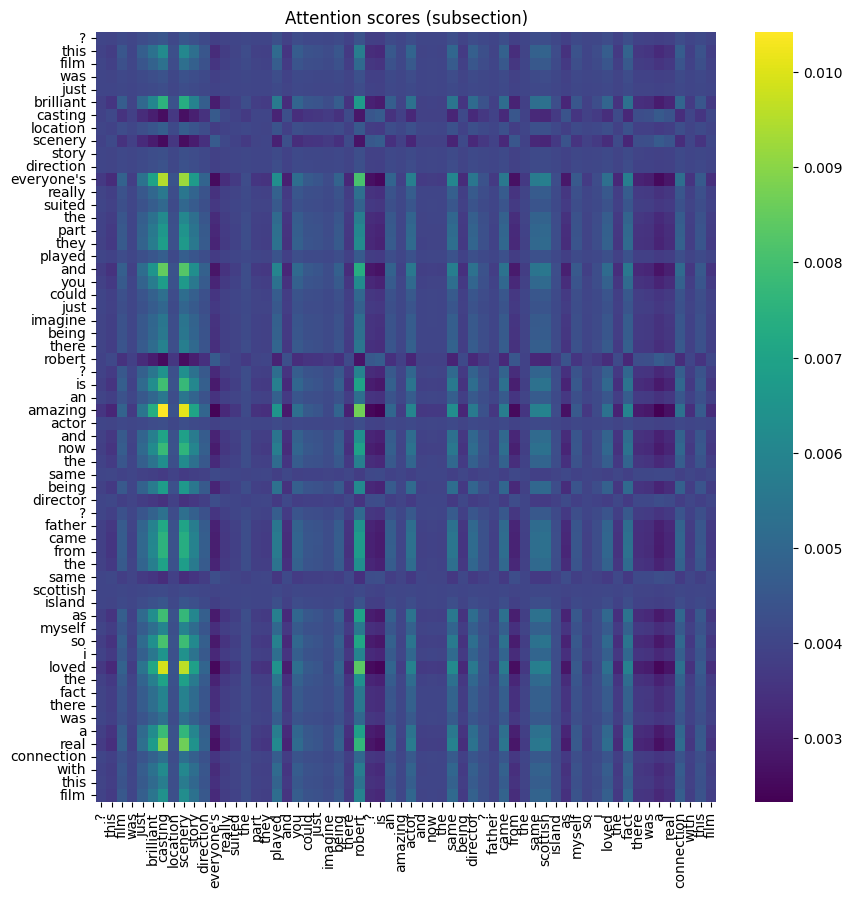

In [27]:
import matplotlib.pyplot as plt

word_to_index = imdb.get_word_index()
index_to_word = dict((value, key) for (key, value) in word_to_index.items())

sub_length = 60  # Adjust the length of the subsection as needed
sub_scores = attention_scores[:sub_length, :sub_length]

# Plot the attention scores for the subsection
plt.figure(figsize=(10, 10))
sns.heatmap(sub_scores, 
            cmap='viridis',
            xticklabels=[index_to_word.get(i-3, '?') for i in sample_input[0][:sub_length]],
            yticklabels=[index_to_word.get(i-3, '?') for i in sample_input[0][:sub_length]])
plt.title('Attention scores (subsection)')
plt.show()